# Biblioteki

In [70]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque
import statistics

## Konfiguracja

In [71]:
FILENAME = "facebook_combined.txt"
SHOW_NEIGHBORS = True
MAX_NEIGHBORS = 20
NODE_START = 0
NODE_END = 4038

## Wczytywanie grafu

In [72]:
def load_graph(filepath: str) -> nx.Graph:
    """Loads a graph from a text file containing an edge list."""
    return nx.read_edgelist(filepath, create_using=nx.Graph(), nodetype=int)

## Tworzenie podgrafu ścieżki

In [73]:
def get_path_subgraph(
    graph: nx.Graph,
    path: list[int],
    show_neighbors: bool = True,
    max_neighbors: int = 20,
) -> nx.Graph:
    """Creates a subgraph containing the shortest path and optional immediate neighbors."""
    nodes_to_draw = set(path)

    if show_neighbors:
        for node in path:
            neighbors = list(graph.neighbors(node))
            nodes_to_draw.update(neighbors[:max_neighbors])

    return graph.subgraph(nodes_to_draw)


## Wizualizacja sieci i zaznaczenie ścieżki

In [74]:
def draw_network(
    subgraph: nx.Graph, path: list[int], title: str = "Network Visualization"
) -> None:
    """Visualizes the subgraph using Matplotlib, highlighting the shortest path."""
    node_colors = []
    node_sizes = []

    for node in subgraph.nodes():
        if node in path:
            node_colors.append("red")
            node_sizes.append(300)
        else:
            node_colors.append("lightgray")
            node_sizes.append(50)

    path_edges = list(zip(path, path[1:]))
    edge_colors = []
    edge_widths = []

    for u, v in subgraph.edges():
        if (u, v) in path_edges or (v, u) in path_edges:
            edge_colors.append("red")
            edge_widths.append(2.0)
        else:
            edge_colors.append("#e0e0e0")
            edge_widths.append(0.5)

    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(subgraph, k=0.5, seed=42)

    nx.draw_networkx_edges(subgraph, pos, edge_color=edge_colors, width=edge_widths, alpha=0.7)
    nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors, node_size=node_sizes)

    labels = {node: str(node) for node in path}
    nx.draw_networkx_labels(subgraph, pos, labels=labels, font_size=10, font_weight="bold")

    plt.title(title)
    plt.axis("off")
    plt.show()


## Wczytanie grafu

In [75]:
try:
    G_fb = load_graph(FILENAME)
except FileNotFoundError:
    print(f"Błąd: Nie znaleziono pliku {FILENAME}")

In [88]:
def print_stats(graph: nx.Graph):
    """Calculates, prints basic properties, and returns stats for plotting.

    Args:
        graph: The NetworkX graph to analyze.

    Returns:
        A tuple containing:
        - List of degrees (int)
        - Average degree (float)
        - Median degree (float)
    """
    num_nodes = graph.number_of_nodes()
    num_edges = graph.number_of_edges()
    density = nx.density(graph)

    degrees = [deg for node, deg in graph.degree()]

    avg_degree = statistics.mean(degrees)
    median_degree = statistics.median(degrees)
    max_degree = max(degrees)

    print("\n--- DANE O GRAFIE ---")
    print(f"Liczba węzłów: {num_nodes}")
    print(f"Liczba krawędzi: {num_edges}")
    print(f"Gęstość grafu: {density:.4f}")
    print(f"Średnia liczba znajomych: {avg_degree:.2f}")
    print(f"Mediana liczby znajomych: {median_degree}")
    print(f"Maksymalna liczba znajomych: {max_degree}")
    print("--------------------------------------\n")


In [89]:
print_stats(G_fb)


--- DANE O GRAFIE ---
Liczba węzłów: 4039
Liczba krawędzi: 88234
Gęstość grafu: 0.0108
Średnia liczba znajomych: 43.69
Mediana liczby znajomych: 25
Maksymalna liczba znajomych: 1045
--------------------------------------



## Top-10 najpopularniejszych (degree)

In [78]:
def print_top_degree(G, k=10):
    top = sorted(G.degree(), key=lambda x: x[1], reverse=True)[:k]
    print("Top users (id, degree):", top)

In [79]:
print_top_degree(G_fb)

Top users (id, degree): [(107, 1045), (1684, 792), (1912, 755), (3437, 547), (0, 347), (2543, 294), (2347, 291), (1888, 254), (1800, 245), (1663, 235)]


## Polecenia rekomendacji znajomych na podstawie wspólnych znajomych
Funkcja recommend ma na celu prostą rekomendację „znajomych znajomych” w sieci społecznościowej. Dla zadanego użytkownika u liczy, ilu wspólnych sąsiadów (common neighbors) ma z innymi użytkownikami, z którymi jeszcze nie jest połączony. Wynik to lista potencjalnych nowych znajomych posortowana według liczby wspólnych znajomych — im więcej wspólnych znajomych, tym wyższa pozycja na liście. To klasyczny przykład rekomendacji w grafach społecznościowych opartych na lokalnej strukturze sieci.

In [80]:
def recommend(G, u, topn=10):
    if u not in G: return []
    neighbors_u = set(G[u])
    score = {}
    for n in neighbors_u:
        for cand in G[n]:
            if cand == u or cand in neighbors_u: continue
            score[cand] = score.get(cand, 0) + 1
    return sorted(score.items(), key=lambda x: x[1], reverse=True)[:topn]

In [81]:
import random

# Losujemy 5 użytkowników z grafu
sample_users = random.sample(list(G_fb.nodes), 5)

# Generujemy rekomendacje dla każdego
for user in sample_users:
    recs = recommend(G_fb, user, topn=5)
    print(f"Rekomendacje dla użytkownika {user}: {recs}")

Rekomendacje dla użytkownika 2981: [(3026, 19), (2683, 18), (3090, 18), (2738, 17), (3084, 17)]
Rekomendacje dla użytkownika 1378: [(958, 23), (1747, 19), (1186, 16), (1784, 15), (1424, 14)]
Rekomendacje dla użytkownika 1249: [(1709, 14), (1472, 9), (1815, 9), (1624, 9), (1070, 8)]
Rekomendacje dla użytkownika 3016: [(3132, 18), (3397, 17), (3330, 17), (3035, 17), (3049, 17)]
Rekomendacje dla użytkownika 360: [(475, 30), (374, 28), (559, 27), (465, 26), (483, 26)]


## Ego-network — rysowanie podgrafu

In [82]:
def plot_ego(G, user, radius=1):
    ego = nx.ego_graph(G, user, radius=radius)

    node_colors = ['red' if n == user else 'lightgray' for n in ego.nodes()]

    nx.draw(ego, node_size=100, node_color=node_colors, with_labels=False)
    plt.title(f"Ego-network: {user}")
    plt.show()

Losowo wybrany użytkownik: 3442


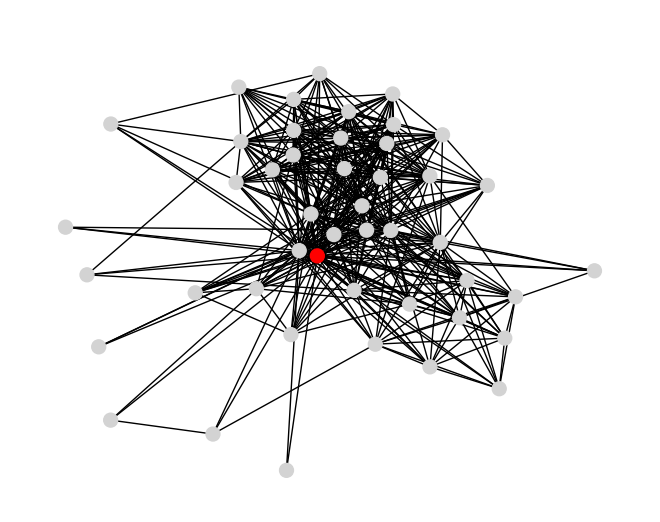

In [83]:
random_user = random.choice(list(G_fb.nodes))
print(f"Losowo wybrany użytkownik: {random_user}")

# Rysujemy ego-network dla tego użytkownika
plot_ego(G_fb, random_user, radius=1)

## Wykrywanie społeczności (Louvain)
Wykrywanie społeczności metodą Louvain polega na podziale węzłów grafu na grupy („społeczności”), które mają więcej połączeń wewnętrznych niż z resztą sieci. Algorytm działa iteracyjnie: najpierw przypisuje każdy węzeł do społeczności swoich sąsiadów, tak aby maksymalizować modularność, czyli miarę gęstości połączeń wewnątrz grupy, a następnie łączy węzły należące do tej samej społeczności w „super-węzły” i powtarza proces na nowym grafie, aż modularność nie wzrośnie. Wynikiem jest przypisanie każdemu węzłowi identyfikatora społeczności, co pozwala zidentyfikować naturalne grupy w sieci, np. grupy przyjaciół lub kliki, i umożliwia ich wizualizację lub analizę statystyczną.

In [84]:
import community as community_louvain
partition = community_louvain.best_partition(G_fb)
# liczba społeczności i przykładowe przypisania
from collections import Counter
print("Communities:", Counter(partition.values()).most_common()[:5])

Communities: [(8, 548), (4, 535), (7, 447), (1, 430), (3, 423)]


## Algorytm BFS — najkrótsza ścieżka

In [85]:
def bfs_shortest_path(graph: nx.Graph, source: int, target: int) -> list[int]:
    """Computes the shortest path using BFS in an unweighted graph."""
    if source not in graph:
        raise ValueError(f"Source node {source} not found in graph.")
    if target not in graph:
        raise ValueError(f"Target node {target} not found in graph.")

    visited = set()
    queue = deque([source])
    visited.add(source)
    parent = {source: None}

    while queue:
        current = queue.popleft()
        if current == target:
            path = []
            while current is not None:
                path.append(current)
                current = parent[current]
            path.reverse()
            return path

        for neighbor in graph.neighbors(current):
            if neighbor not in visited:
                visited.add(neighbor)
                queue.append(neighbor)
                parent[neighbor] = current

    raise RuntimeError("No path exists between the specified nodes.")

Szukanie najkrótszej ścieżki między 0 a 4038...
Znaleziono ścieżkę! Długość (liczba krawędzi): 5


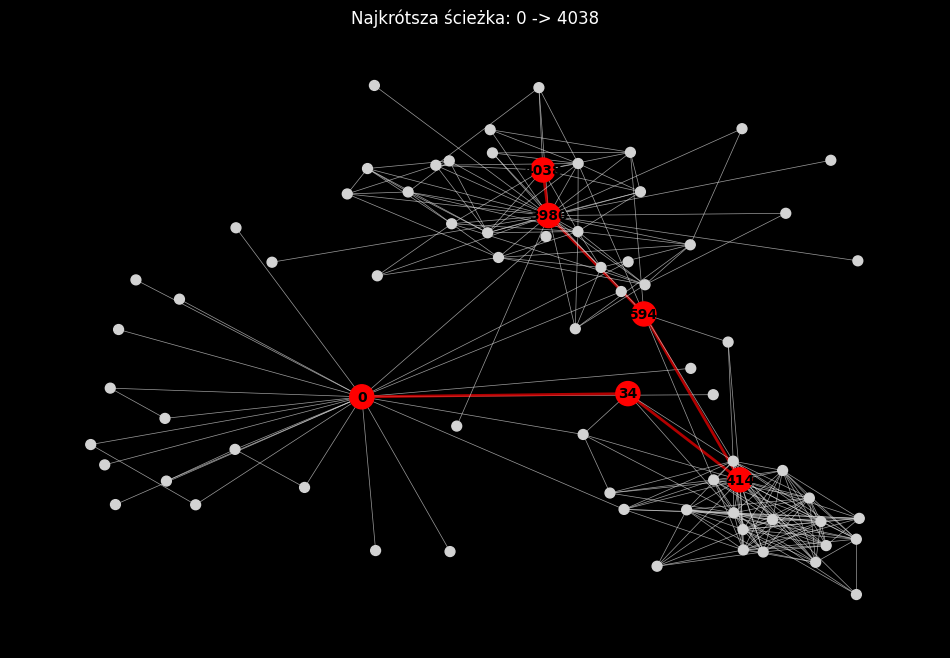

In [86]:
try:
    print(f"Szukanie najkrótszej ścieżki między {NODE_START} a {NODE_END}...")
    path = bfs_shortest_path(G_fb, NODE_START, NODE_END)
    print(f"Znaleziono ścieżkę! Długość (liczba krawędzi): {len(path)-1}")
except ValueError as e:
    print(f"Błąd: {e}")
except RuntimeError as e:
    print(f"{e}")

subgraph = get_path_subgraph(G_fb, path, show_neighbors=SHOW_NEIGHBORS, max_neighbors=MAX_NEIGHBORS)
draw_network(subgraph, path, title=f"Najkrótsza ścieżka: {NODE_START} -> {NODE_END}")